# 데이터 설명입니다

SUMMARY
================================================================================

This dataset was constructed by YOOCHOOSE GmbH to support participants in the RecSys Challenge 2015.
See  http://recsys.yoochoose.net for details about the challenge.

The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session
is encapsulating the click events that the user performed in the session.
For some of the sessions, there are also buy events; means that the session ended
with the user bought something from the web shop. The data was collected during several
months in the year of 2014, reflecting the clicks and purchases performed by the users
of an on-line retailer in Europe.  To protect end users privacy, as well as the retailer,
all numbers have been modified. Do not try to reveal the identity of the retailer.

LICENSE
================================================================================
This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0
International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd/4.0/.
YOOCHOOSE cannot guarantee the completeness and correctness of the data or the validity
of results based on the use of the dataset as it was collected by implicit tracking of a website.
If you have any further questions or comments, please contact YooChoose <support@YooChoose.com>.
The data is provided "as it is" and there is no obligation of YOOCHOOSE to correct it,
improve it or to provide additional information about it.

CLICKS DATASET FILE DESCRIPTION
================================================================================
The file yoochoose-clicks.dat comprising the clicks of the users over the items.
Each record/line in the file has the following fields/format: Session ID, Timestamp, Item ID, Category
-Session ID – the id of the session. In one session there are one or many clicks. Could be represented as an integer number.
-Timestamp – the time when the click occurred. Format of YYYY-MM-DDThh:mm:ss.SSSZ
-Item ID – the unique identifier of the item that has been clicked. Could be represented as an integer number.
-Category – the context of the click. The value "S" indicates a special offer, "0" indicates  a missing value, a number between 1 to 12 indicates a real category identifier,
 any other number indicates a brand. E.g. if an item has been clicked in the context of a promotion or special offer then the value will be "S", if the context was a brand i.e BOSCH,
 then the value will be an 8-10 digits number. If the item has been clicked under regular category, i.e. sport, then the value will be a number between 1 to 12.

BUYS DATSET FILE DESCRIPTION
================================================================================
The file yoochoose-buys.dat comprising the buy events of the users over the items.
Each record/line in the file has the following fields: Session ID, Timestamp, Item ID, Price, Quantity

-Session ID - the id of the session. In one session there are one or many buying events. Could be represented as an integer number.
-Timestamp - the time when the buy occurred. Format of YYYY-MM-DDThh:mm:ss.SSSZ
-Item ID – the unique identifier of item that has been bought. Could be represented as an integer number.
-Price – the price of the item. Could be represented as an integer number.
-Quantity – the quantity in this buying.  Could be represented as an integer number.

TEST DATASET FILE DESCRIPTION
================================================================================
The file yoochoose-test.dat comprising only clicks of users over items.
This file served as a test file in the RecSys challenge 2015.
The structure is identical to the file yoochoose-clicks.dat but you will not find the
corresponding buying events to these sessions in the yoochoose-buys.dat file.

# 시작

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocess
## 2.1. Data Load
* 데이터를 불러와 살펴보고, 주요 통계치들을 살표보기
* Click 데이터에 있는 Session Id, TimeStamp, ItemId 칼럼만 사용하기

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [7]:
## 각자 드라이브 위치로 경로를 잘 바꿔주세요~
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data')
#train_path = '/content/drive/MyDrive/Colab Notebooks/데싸4기/추천시스템/data/yoochoose-clicks.dat'
train_path = data_path / 'yoochoose-clicks.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/yoochoose-clicks.dat')

# 결측치오류

- LMS 코드를 그대로 사용하면 결측치 오류가 납니다 (주석은 LMS 코드, 아래는 한달치 코드)

In [ ]:
# def load_data(data_path: Path, nrows=None):
#     data = pd.read_csv(
#         data_path,
#         sep=',',
#         header=None,
#         usecols=[0, 1, 2],
#         parse_dates=[1],
#         dtype={0: np.int32, 2: np.int32},
#         nrows=nrows
#     )
#     data.columns = ['SessionId', 'Time', 'ItemId']

#     # 결측값 제거
#     data.dropna(subset=['ItemId'], inplace=True)

#     return data

In [ ]:
# 시간이 좀 걸릴 수 있습니다. 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의해 주세요.

# data = load_data(train_path, None)
# data.sort_values(['SessionId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
# # data

# 메모리 오류

위 코드를 사용하면 메모리 오류가난다

밑에서 어차피 최근 1달동안의 데이터만 쓰기때문에

미리 잘라서 가져와보자

In [3]:
def load_recent_data(data_path, cutoff_days=30):
    chunk_size = 5_000_000
    chunks = []

    print("📅 [1/3] 최신 날짜 찾는 중...")
    latest = None
    total_chunks = 0
    for i, chunk in enumerate(pd.read_csv(
        data_path,
        sep=',',
        header=None,
        usecols=[0, 1, 2],
        parse_dates=[1],
        dtype={0: np.int32, 2: np.int32},
        chunksize=chunk_size
    )):
        max_time = chunk[1].max()
        if latest is None or max_time > latest:
            latest = max_time
        total_chunks += 1
        print(f"  ▸ 최신 날짜 스캔 중... chunk {i+1} 완료")

    print(f"✅ 최신 날짜: {latest}")
    month_ago = latest - dt.timedelta(days=cutoff_days)
    print(f"📆 기준 날짜: {month_ago}")

    print("📦 [2/3] 최근 30일 데이터 필터링 중...")
    matched_rows = 0
    for i, chunk in enumerate(pd.read_csv(
        data_path,
        sep=',',
        header=None,
        usecols=[0, 1, 2],
        parse_dates=[1],
        dtype={0: np.int32, 2: np.int32},
        chunksize=chunk_size
    )):
        chunk.columns = ['SessionId', 'Time', 'ItemId']
        filtered = chunk[chunk['Time'] > month_ago]
        matched_rows += len(filtered)
        if not filtered.empty:
            chunks.append(filtered)
        print(f"  ▸ chunk {i+1} 처리 완료 ({len(filtered)}개 매치됨)")

    data = pd.concat(chunks, ignore_index=True)

    print("🎉 [3/3] 필터링 완료")
    print(f"🧾 최종 데이터 크기: {len(data):,} rows")

    return data

In [ ]:
# 🧠 이 함수의 목적 요약:
# 대규모 로그 데이터에서

# 최신 날짜 기준으로 30일 이내의 기록만 필터링해서

# 메모리 효율적으로 처리한 후 반환합니다.

# def load_recent_data(data_path, cutoff_days=30):
#     chunk_size = 5_000_000  # 한 번에 읽어올 CSV 행 수 (메모리 절약을 위해 chunk 단위로 읽음)
#     chunks = []             # 필터링된 chunk들을 담을 리스트

#     print("📅 [1/3] 최신 날짜 찾는 중...")
#     latest = None           # 데이터 전체에서 가장 최신 날짜를 저장할 변수
#     total_chunks = 0        # chunk 개수 카운트용

#     # 1단계: 전체 파일을 chunk 단위로 읽으며 가장 최신 날짜(max_time)를 찾는다
#     for i, chunk in enumerate(pd.read_csv(
#         data_path,
#         sep=',',                      # CSV 파일 구분자
#         header=None,                 # 헤더 없음
#         usecols=[0, 1, 2],           # 필요한 열만 읽음: SessionId, Time, ItemId
#         parse_dates=[1],            # 두 번째 열(Time)을 날짜 형식으로 파싱
#         dtype={0: np.int32, 2: np.int32},  # 메모리 절약을 위해 정수형 지정
#         chunksize=chunk_size         # 한 번에 읽어올 행 수
#     )):
#         max_time = chunk[1].max()    # 현재 chunk에서 가장 최신 시간
#         if latest is None or max_time > latest:
#             latest = max_time        # 전체에서 가장 최신 시간으로 갱신
#         total_chunks += 1
#         print(f"  ▸ 최신 날짜 스캔 중... chunk {i+1} 완료")

#     print(f"✅ 최신 날짜: {latest}")
#     month_ago = latest - dt.timedelta(days=cutoff_days)  # 기준 날짜 설정: 최신 날짜 - cutoff_days
#     print(f"📆 기준 날짜: {month_ago}")

#     print("📦 [2/3] 최근 30일 데이터 필터링 중...")
#     matched_rows = 0  # 필터링된 행 수 카운트

#     # 2단계: 다시 전체 데이터를 읽으며 기준 날짜 이후의 데이터만 필터링
#     for i, chunk in enumerate(pd.read_csv(
#         data_path,
#         sep=',',
#         header=None,
#         usecols=[0, 1, 2],
#         parse_dates=[1],
#         dtype={0: np.int32, 2: np.int32},
#         chunksize=chunk_size
#     )):
#         chunk.columns = ['SessionId', 'Time', 'ItemId']  # 컬럼명 지정
#         filtered = chunk[chunk['Time'] > month_ago]      # 기준 날짜 이후 데이터만 선택
#         matched_rows += len(filtered)                    # 매치된 행 수 누적
#         if not filtered.empty:
#             chunks.append(filtered)                      # 비어있지 않으면 chunks에 추가
#         print(f"  ▸ chunk {i+1} 처리 완료 ({len(filtered)}개 매치됨)")

#     # 3단계: 필터링된 모든 chunk를 하나의 데이터프레임으로 결합
#     data = pd.concat(chunks, ignore_index=True)

#     print("🎉 [3/3] 필터링 완료")
#     print(f"🧾 최종 데이터 크기: {len(data):,} rows")

#     return data  # 최근 30일치 데이터 반환


In [8]:
# 저는 15분정도 걸렸습니다

data = load_recent_data(train_path)
data.sort_values(['SessionId', 'Time'], inplace=True)

📅 [1/3] 최신 날짜 찾는 중...
  ▸ 최신 날짜 스캔 중... chunk 1 완료
  ▸ 최신 날짜 스캔 중... chunk 2 완료
  ▸ 최신 날짜 스캔 중... chunk 3 완료
  ▸ 최신 날짜 스캔 중... chunk 4 완료
  ▸ 최신 날짜 스캔 중... chunk 5 완료
  ▸ 최신 날짜 스캔 중... chunk 6 완료
  ▸ 최신 날짜 스캔 중... chunk 7 완료
✅ 최신 날짜: 2014-09-30 02:59:59.430000+00:00
📆 기준 날짜: 2014-08-31 02:59:59.430000+00:00
📦 [2/3] 최근 30일 데이터 필터링 중...
  ▸ chunk 1 처리 완료 (0개 매치됨)
  ▸ chunk 2 처리 완료 (0개 매치됨)
  ▸ chunk 3 처리 완료 (0개 매치됨)
  ▸ chunk 4 처리 완료 (0개 매치됨)
  ▸ chunk 5 처리 완료 (0개 매치됨)
  ▸ chunk 6 처리 완료 (2637457개 매치됨)
  ▸ chunk 7 처리 완료 (3003944개 매치됨)
🎉 [3/3] 필터링 완료
🧾 최종 데이터 크기: 5,641,401 rows


In [9]:
data

,SessionId,Time,ItemId
126221,9194111,2014-08-31 17:40:46.805000+00:00,214853420
126222,9194111,2014-08-31 17:42:26.089000+00:00,214850942
126223,9194111,2014-08-31 17:44:06.583000+00:00,214829878
126224,9194111,2014-08-31 17:48:49.873000+00:00,214853420
126317,9194112,2014-09-01 13:26:36.292000+00:00,214853422
...,...,...,...
4867944,11562158,2014-09-26 04:50:29.172000+00:00,214849132
4867945,11562158,2014-09-26 04:52:21.900000+00:00,214854774
4867946,11562158,2014-09-26 05:16:32.904000+00:00,214849132
4867947,11562159,2014-09-26 19:16:28.897000+00:00,214849132


## Session Length
- 각 세션이 몇개의 클릭 데이터를 갖는지 살펴보기
- 데이터 EDA

In [10]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
9194111     4
9194112     1
9194123     3
9194124     2
9194126     1
           ..
11562156    2
11562157    2
11562158    3
11562159    1
11562161    1
Length: 1639032, dtype: int64

* session_length란 같은 SessionId를 공유하는 데이터 row의 개수
* SessionId란 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자,로그인하지 않았기 때문에 이 사용자가 누군지는 알 수 없어도, 최소한 특정 사용자의 행동을 SessionId 기준으로 모아서 분류해낼 수는 있음. 

In [12]:
session_length.median(), session_length.mean()
#* 따라서 여기서 session_length란 해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취했는지(몇 개의 상품정보를 클릭했는지)의 의미.
# 즉 여기서는 sessionid를 공유하는 데이터 row의 수를 median 그리고 mean으로 구분하였음
# 각 세션의 길이

(2.0, 3.441910225059669)

In [13]:
session_length.min(), session_length.max()
#이 경우는 유저 구분자의 최소 그리고 최대를 알아내기 위함임

(1, 200)

In [ ]:
session_length.quantile(0.999)

np.float64(41.0)

* 각 세션의 길이는 보통 2~3 정도입니다. 온라인에서 쇼핑할 때를 생각해 보면 이 수치가 그럴듯하게 느껴집니다.
* 99.9% 세션은 길이가 41이하입니다.길이가 200인 세션은 뭔가 이상합니다.
* 하나를 잡고 살펴봅시다.






In [14]:
long_session = session_length[session_length==200].index[0]
data[data['SessionId']==long_session]

,SessionId,Time,ItemId
1497718,9781279,2014-09-05 12:36:09.590000+00:00,214534211
1497719,9781279,2014-09-05 12:36:14.493000+00:00,214680463
1497720,9781279,2014-09-05 12:36:18.288000+00:00,214587193
1497721,9781279,2014-09-05 12:36:29.075000+00:00,214834978
1497722,9781279,2014-09-05 12:37:59.583000+00:00,214684755
...,...,...,...
1497913,9781279,2014-09-05 15:48:45.346000+00:00,214565557
1497914,9781279,2014-09-05 15:48:55.612000+00:00,214585406
1497915,9781279,2014-09-05 15:49:06.494000+00:00,214581444
1497916,9781279,2014-09-05 15:49:08.383000+00:00,214565535


매우 짧은 간격으로 지속적으로 클릭을 1시간 30분가량 지속하고 있습니다.
유저들의 서비스 이용행태는 다양하기 때문에 데이터 전처리를 어떻게 할지는 모델을 만드는 사람이 판단해야 합니다.
e.g.) 음악 데이터의 경우 어떤 사람은 하루 종일 랜덤 재생을 할 수도 있습니다. 이 유저의 데이터를 그대로 사용하는 게 좋을까요?
e.g.) 어떤 상품의 경우 1분 내에 20명이 10점을 주고 나갈 수도 있습니다. 이 상품을 팔기 위해 조작하고 있는 건 아닐까요?

너무 긴 세션을 제거할 수도 있고 포함시킬 수도 있습니다. 어떻게 하면 좋을지 판단해 보세요.

세션 길이에 대한 감을 더 잘 파악하기 위해 시각화를 해보겠습니다. 아래는 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화한 것입니다.






In [15]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1     0.220500
2     0.556013
3     0.708616
4     0.802125
5     0.856219
6     0.894427
7     0.918897
8     0.937228
9     0.949918
10    0.959849
11    0.967048
12    0.972919
13    0.977373
14    0.981030
15    0.983903
16    0.986304
17    0.988186
18    0.989821
19    0.991083
20    0.992187
21    0.993125
22    0.993929
23    0.994665
24    0.995272
25    0.995760
26    0.996192
27    0.996590
28    0.996934
29    0.997228
30    0.997495
31    0.997723
32    0.997937
33    0.998112
34    0.998264
35    0.998401
36    0.998541
37    0.998655
38    0.998757
39    0.998857
40    0.998944
dtype: float64

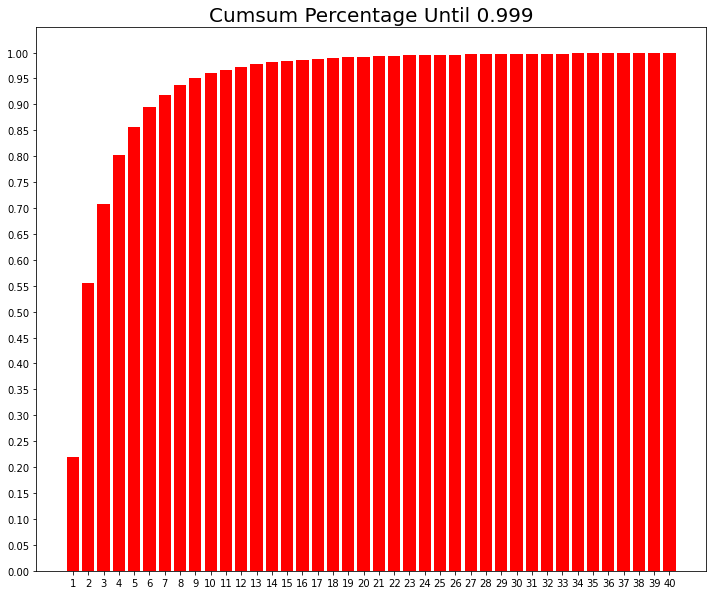

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

추천시스템은 유저-상품 관계 매트릭스를 유저 행렬과 상품 행렬의 곱으로 표현하는 Matrix Factorization 모델을 널리 사용합니다. 그렇다면 이 데이터도 유저와 클릭한 상품정보 관계에 대해 Matrix Factorization을 사용하면 어떨까요?

User * Item Matrix의 빈칸이 너무 많아서(data sparsity) 모델이 제대로 학습되지 않을 가능성이 있다. 이 세션정보는 유저를 ID 기반으로 정리할 수 없기 때문에 세션 하나를 유저 하나로 본다면 기존의 유저-상품정보 Matrix보다 훨씬 sparse한 형태가 된다.



## Session Time
* 추천 시스템을 구축하기 앞서 최근 소비 트렌드를 학습하기
* 접속하는 시간대(오전, 오후, 새벽), 접속해 있는 시간, 접속하는 요일, 계절, 마지막 접속 시간, 장바구니에 넣고 지난 시간 등등




In [18]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2014-08-31 03:00:01.111000+00:00
2014-09-30 02:59:59.430000+00:00


In [20]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [21]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다.
data

,SessionId,Time,ItemId
126221,9194111,2014-08-31 17:40:46.805000+00:00,214853420
126222,9194111,2014-08-31 17:42:26.089000+00:00,214850942
126223,9194111,2014-08-31 17:44:06.583000+00:00,214829878
126224,9194111,2014-08-31 17:48:49.873000+00:00,214853420
126317,9194112,2014-09-01 13:26:36.292000+00:00,214853422
...,...,...,...
4867944,11562158,2014-09-26 04:50:29.172000+00:00,214849132
4867945,11562158,2014-09-26 04:52:21.900000+00:00,214854774
4867946,11562158,2014-09-26 05:16:32.904000+00:00,214849132
4867947,11562159,2014-09-26 19:16:28.897000+00:00,214849132


# 전처리
## Data Cleansing

한 세션에서 2번 이상 클릭안한 제품을 제거

전체에서 5번이상 클릭 안한 제품을 제거

In [22]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [ ]:
# # short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# # 이를 방지하기 위해 두 정제 작업을 반복해서 수행합니다.
# def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
#     while True:
#         before_len = len(data)  # 정제 전 데이터 길이 저장
#         data = cleanse_short_session(data, shortest)         # 짧은 세션 제거
#         data = cleanse_unpopular_item(data, least_click)     # 클릭 수 적은 아이템 제거
#         after_len = len(data)   # 정제 후 데이터 길이 저장
#         if before_len == after_len:  # 데이터 길이가 변하지 않으면 종료
#             break
#     return data  # 정제 완료된 데이터 반환


# # 특정 길이보다 짧은 세션(SessionId)을 제거하는 함수
# def cleanse_short_session(data: pd.DataFrame, shortest):
#     session_len = data.groupby('SessionId').size()            # 각 세션별 클릭 수 계산
#     session_use = session_len[session_len >= shortest].index  # 기준 이상 길이의 세션만 추출
#     data = data[data['SessionId'].isin(session_use)]          # 해당 세션만 유지
#     return data

# # 특정 횟수 이하로 클릭된 비인기 아이템(ItemId)을 제거하는 함수
# def cleanse_unpopular_item(data: pd.DataFrame, least_click):
#     item_popular = data.groupby('ItemId').size()              # 각 아이템의 총 클릭 수 계산
#     item_use = item_popular[item_popular >= least_click].index  # 기준 이상 클릭된 아이템만 추출
#     data = data[data['ItemId'].isin(item_use)]                # 해당 아이템만 유지
#     return data


In [23]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,Time,ItemId
126221,9194111,2014-08-31 17:40:46.805000+00:00,214853420
126222,9194111,2014-08-31 17:42:26.089000+00:00,214850942
126223,9194111,2014-08-31 17:44:06.583000+00:00,214829878
126224,9194111,2014-08-31 17:48:49.873000+00:00,214853420
126314,9194123,2014-08-31 19:26:57.386000+00:00,214601207
...,...,...,...
4867942,11562157,2014-09-25 12:31:10.391000+00:00,214580372
4867943,11562157,2014-09-25 12:31:29.679000+00:00,214516012
4867944,11562158,2014-09-26 04:50:29.172000+00:00,214849132
4867945,11562158,2014-09-26 04:52:21.900000+00:00,214854774


# 테스트셋 확인

확인해보니까 일자가 겹쳐서
기존 data를 활용해서 만들기로

In [ ]:
# test_path = data_path / 'yoochoose-test.dat'
# test= load_data(test_path)
# test['Time'].min(), test['Time'].max()

In [24]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [25]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [26]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [27]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5125100
	 Sessions: 1243431
	 Items: 20153
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58074
	 Sessions: 12350
	 Items: 6232
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71009
	 Sessions: 15289
	 Items: 6580
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



In [28]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [29]:
from pathlib import Path

save_path = Path('./processed')
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 전처리 끝

## Data pipeline

In [37]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [39]:
# 이 SessionDataset 클래스를 사용하는 목적은 단 하나입니다:
# 🎯 세션 기반 추천 모델(RNN 기반)에서,
# 각 세션을 시퀀스 형태로 쉽게 가져오기 위한 인덱싱 구조를 만드는 것.

# class SessionDataset:
#     """세션 기반 추천을 위한 데이터셋 클래스 정의.
#     참고: yhs-968/pyGRU4REC 구현 기반"""

#     def __init__(self, data):
#         self.df = data  # 전체 세션-클릭 로그 데이터를 저장
#         self.click_offsets = self.get_click_offsets()  # 각 세션이 시작하는 위치 인덱스 배열 생성
#         self.session_idx = np.arange(self.df['SessionId'].nunique())  # 고유한 세션 개수만큼의 인덱스 배열 생성

#     def get_click_offsets(self):
#         """
#         각 세션이 df 내에서 시작하는 인덱스를 계산하여 배열로 반환
#         예: 세션별 클릭 수가 [3, 2, 4]라면 -> [0, 3, 5, 9] 반환
#         """
#         # 고유한 세션 개수 + 1 크기의 0으로 채워진 배열 생성
#         offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)

#         # 세션별 클릭 수를 누적합으로 계산하여 offset[1:]에 저장
#         # 이때 cumsum()은 각 세션의 끝 인덱스를 나타냄
#         offsets[1:] = self.df.groupby('SessionId').size().cumsum()

#         return offsets  # 세션별 시작 인덱스를 담은 배열


| 구현 목적        | 설명                                       |
| ------------ | ---------------------------------------- |
| ✅ 세션 시퀀스 추출  | RNN 입력으로 쓸 수 있는 클릭 시퀀스 추출                |
| ✅ 성능 최적화     | 슬라이싱을 빠르고 안정적으로 하기 위한 offset 구조          |
| ✅ 모델 학습용 전처리 | GRU4Rec, STAMP 등 session-aware 모델에 연결 가능 |


In [38]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
126221,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
126222,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
126223,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
126224,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
126314,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
126315,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
126308,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
126309,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
126311,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
126312,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [32]:
tr_dataset.click_offsets

array([      0,       4,       6, ..., 5125095, 5125097, 5125100],
      dtype=int32)

In [33]:
tr_dataset.session_idx

array([      0,       1,       2, ..., 1243428, 1243429, 1243430])

## Session Dataloader 

* 반복 가능한 객체 알아보기 - https://dojang.io/mod/page/view.php?id=2405
* SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
* __iter__ 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
* mask는 후에 RNN Cell State를 초기화하는데 사용할 것입니다.


핵심 역할:
- 한 번에 batch_size만큼의 세션을 병렬로 처리
- 세션 길이가 다르기 때문에, 가장 짧은 세션 기준으로만 동시 진행
- 세션이 끝난 자리는 다음 세션으로 교체
- 즉, 각 세션별로 데이터프레임에서 시작과 끝을 인덱싱한 것 

In [40]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.

        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [41]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
126221,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
126222,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
126223,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
126224,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
126314,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
126315,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
126308,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
126309,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
126311,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
126312,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [42]:
iter_ex = iter(tr_data_loader)

## 4.2. Session DataLoader

In [43]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 7]
Label Item Idx are :       [1 4 6 7]
Previous Masked Input Idx are []


📌 이 코드의 목적은?
세션 기반 추천 모델이 생성한 추천 결과(pred) 에 대해

실제 정답이 얼마나 빨리 나왔는가(MRR), 들어는 있었는가(Recall) 를 평가하는 함수입니다.

실무에서는 이 두 지표를 평균(MRR@k, Recall@k) 내어 전체 모델 성능을 측정합니다.



In [47]:
import numpy as np

def mrr_k(pred, truth: int, k: int):
    """
    MRR@k (Mean Reciprocal Rank) 계산 함수
    - pred: 모델이 예측한 추천 아이템 리스트 (1차원 배열)
    - truth: 실제 유저가 클릭한 정답 아이템 (int)
    - k: top-k까지의 예측 결과만 평가

    반환값:
    - 정답이 pred[:k]에 포함되어 있으면, 해당 위치의 역수 (1 / 순위)
    - 없으면 0
    """
    indexing = np.where(pred[:k] == truth)[0]  # 정답이 top-k 내에 있는지 위치(인덱스) 찾기
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)           # 순위는 1-based이므로 index + 1의 역수 반환
    else:
        return 0                               # 정답이 top-k에 없으면 점수는 0


def recall_k(pred, truth: int, k: int) -> int:
    """
    Recall@k 계산 함수
    - pred: 모델이 예측한 추천 아이템 리스트 (1차원 배열)
    - truth: 실제 유저가 클릭한 정답 아이템 (int)
    - k: top-k까지의 예측 결과만 평가

    반환값:
    - 정답이 pred[:k] 안에 있으면 1, 아니면 0
    """
    answer = truth in pred[:k]  # 정답이 top-k 추천 목록에 포함되었는지 여부
    return int(answer)          # 포함되면 1, 아니면 0 (int형으로 반환)


## Modeling

* 모델 성능 평가를 위한 지표 평가, precision이나 recall
- Session-Based Recommendation Task에서는, 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋음.
- 이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용.
- 추천에서는 몇 번째로 맞추느냐도 중요 - 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것.따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용.

- 이번 자료에서는 MRR과 Recall@k를 사용하겠습니다. MRR은 정답 아이템이 나온 순번의 역수 값입니다. 따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것입니다.

🎯 배경: 추천 시스템에서의 "정답"이란?
사용자가 세션 내에서 클릭하거나 구매한 실제 아이템이 “정답”입니다.
모델은 추천 리스트(k개)를 제시하고,
그 안에 정답이 들어 있는지 / 몇 번째에 있는지로 성능을 평가합니다.

✅ 왜 precision이나 recall만으론 부족한가?
일반적인 분류 문제에서는 “맞췄냐/틀렸냐”만 중요하지만,

추천 시스템에서는 "정답이 얼마나 위에 있느냐" 도 중요합니다.

예:

검색 결과가 10페이지 중 8페이지에 나와도 technically 맞긴 하지만,
실제 사용자 입장에서는 무의미하죠.

📊 주요 지표 설명
1️⃣ Recall@k
모델이 상위 k개의 아이템을 추천했을 때,

그 안에 정답 아이템이 있으면 1, 없으면 0

Recall@k = (# 정답 포함된 세션 수) / (전체 세션 수)
✅ 강점: "정답을 포함했는가"를 측정
❌ 약점: 정답이 몇 번째인지는 고려하지 않음

2️⃣ MRR (Mean Reciprocal Rank)
정답이 나온 순번의 역수를 평균한 값
예: 정답이 1등이면 1.0, 2등이면 0.5, 3등이면 0.333...
MRR = 평균(1 / 정답 순위)
✅ 강점: 정답을 얼마나 빨리 보여줬는가 측정
❌ 약점: 정답이 여러 개일 경우 대표 하나만 반영

3️⃣ (참고) MAP@k (Mean Average Precision)
Precision을 세션 단위 누적 평균으로 확장한 지표

예: 정답이 여러 개인 경우, 여러 개의 정답 중 얼마나 많이, 얼마나 앞에서 맞췄는가 반영

🧪 왜 Recall@k + MRR을 같이 쓰나?


| 지표        | 무엇을 측정하나?        | 직관적인 의미      |
| --------- | ---------------- | ------------ |
| Recall\@k | 정답이 Top-k 안에 있냐? | 추천에 성공했는가    |
| MRR       | 정답이 얼마나 위에 있냐?   | 사용자 만족에 가까운가 |


→ Recall@k는 포괄적인 정확성,
→ MRR은 사용자 체감 만족도(탑에 가까운가?) 를 측정합니다.

📝 요약
추천 시스템의 평가는 단순히 맞추는 것만이 아니라,
얼마나 빠르게(위쪽에서) 맞췄느냐도 매우 중요합니다.

따라서:

Recall@k → “맞췄니?”

MRR → “얼마나 빨리 맞췄니?”

를 같이 쓰는 것이 일반적입니다.



## Model Architecture

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [49]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [48]:
def create_model(args):
    """
    GRU 기반의 세션 추천 모델 생성 함수
    - 입력: args (모델 하이퍼파라미터가 저장된 객체)
    - 출력: 컴파일된 Keras 모델 객체
    """

    # (batch_size, time_steps, num_items) 형태의 입력 정의
    # → 예: one-hot 인코딩된 아이템 시퀀스
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))  

    # GRU 레이어 생성 (stateful=True로 세션별 상태 유지)
    # - args.hsz: hidden state 크기
    # - return_state=True: 마지막 hidden state도 반환
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)

    # Dropout 레이어로 과적합 방지
    dropout = Dropout(args.drop_rate)(gru)

    # 출력 레이어: 아이템 수만큼의 softmax 확률 분포
    predictions = Dense(args.num_items, activation='softmax')(dropout)

    # 모델 구성: 입력 → GRU → Dropout → Dense → 예측
    model = Model(inputs=inputs, outputs=[predictions])

    # 모델 컴파일 (손실 함수: categorical crossentropy, 옵티마이저: Adam)
    model.compile(
        loss=categorical_crossentropy,
        optimizer=Adam(args.lr),
        metrics=['accuracy']
    )

    # 모델 구조 출력
    model.summary()

    return model  # 학습 가능한 모델 반환

In [50]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [51]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 20153)]        0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  3030750   
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 20153)             1027803   
Total params: 4,058,553
Trainable params: 4,058,553
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [52]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)

## 모델을 가져오는 과정에서 수정이 필요합니다
def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다.
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()

    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        # pred = model(input_ohe, training=False)

        # # 🔥 dict이면 첫 번째 값만 추출
        # if isinstance(pred, dict):
        #     pred = list(pred.values())[0]

        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [ ]:
train_model(model, args)

In [ ]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.


from keras.layers import TFSMLayer

# ## colab에서 하면 keras 모델을 불러오는 방법이 달라집니다 load model을 하려면 keras 로 저장했어야하는데 h5 형태이기때문
# model = TFSMLayer(
#     "/content/drive/MyDrive/Colab Notebooks/데싸4기/추천시스템/data/trained_model",
#     call_endpoint="serving_default"  # 보통 이 이름이 맞지만 다른 경우도 있음
# )

## Inference

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)